# 強化学習アルゴリズム比較: ランダムエージェント vs DQN vs PPO

このノートブックは、3つの強化学習アプローチの包括的な比較を提供します:
- **ランダムエージェント**: ランダムに行動を選択するベースラインエージェント
- **DQN (Deep Q-Network)**: Q値を学習する価値ベースのRLアルゴリズム
- **PPO (Proximal Policy Optimization)**: Actor-Criticアーキテクチャを使用する方策ベースのRLアルゴリズム

## 目的
1. パフォーマンス指標の比較（成功率、報酬、エピソード長）
2. ニューラルネットワークアーキテクチャの可視化
3. 推論パフォーマンスのベンチマーク
4. アルゴリズムの違いの理解

## セットアップとインポート

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add parent directory to path for imports
sys.path.append(str(Path.cwd().parent))

# RL libraries
import gymnasium as gym
from stable_baselines3 import DQN, PPO

# Visualization
import torch

# Optional: torchviz and torchsummary (for architecture visualization)
# These require Graphviz to be installed on your system
try:
    from torchviz import make_dot
    from torchsummary import summary
    TORCHVIZ_AVAILABLE = True
    print("✓ torchviz and torchsummary available")
except ImportError as e:
    TORCHVIZ_AVAILABLE = False
    print(f"⚠ torchviz/torchsummary not available: {e}")
    print("  Architecture graph visualization will be skipped.")
    print("  To enable: install Graphviz from https://graphviz.org/download/")
    print("  and add it to your system PATH, then: pip install torchviz torchsummary")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✓ All required imports successful")

✓ torchviz and torchsummary available
✓ All required imports successful


## 設定

In [2]:
# Model paths
MODEL_DIR = Path('../ml/models')
DQN_MODEL_PATH = MODEL_DIR / 'dqn_maze.zip'
PPO_MODEL_PATH = MODEL_DIR / 'ppo_cartpole.zip'

# Evaluation settings
N_EVAL_EPISODES = 100
N_INFERENCE_CALLS = 1000

# Environment
ENV_NAME = 'CartPole-v1'

print(f"Configuration loaded:")
print(f"  Environment: {ENV_NAME}")
print(f"  Evaluation episodes: {N_EVAL_EPISODES}")
print(f"  Inference benchmark calls: {N_INFERENCE_CALLS}")

Configuration loaded:
  Environment: CartPole-v1
  Evaluation episodes: 100
  Inference benchmark calls: 1000


## アルゴリズムの説明

比較に入る前に、評価する3つのアプローチの基本的な違いを理解しましょう。

### ランダムエージェント（ベースライン）

**ランダムエージェント**は比較のベースラインとして機能します。何も学習せず、利用可能な行動空間からランダムに行動を選択するだけです。

**主な特徴:**
- **学習なし**: 方策なしでランダムに行動を選択
- **ニューラルネットワークなし**: 訓練や最適化するパラメータなし
- **探索のみ**: 活用なしの純粋な探索
- **パフォーマンス**: 通常は低いが、比較の下限を提供

**使用例:**
- 学習進捗を測定するためのベースライン
- 訓練されたエージェントがランダムな動作を上回ることの健全性チェック
- 完全に未知の環境での初期探索

### DQN (Deep Q-Network) - 価値ベース手法

**DQN**は、各状態-行動ペアのQ値（行動価値）を推定することを学習する価値ベースの強化学習アルゴリズムです。2015年にDeepMindによって導入され、深層学習をRLに適用する画期的な成果となりました。

**核となる概念:**
- Q関数を学習: Q(s, a) → 状態's'で行動'a'を取ったときの期待累積報酬
- ニューラルネットワーク（Q-Network）を使用してQ値を近似
- 最も高いQ値を持つ行動を選択（貪欲方策）

**主要コンポーネント:**
1. **Q-Network**: 状態を入力とし、すべての行動のQ値を出力するニューラルネットワーク
2. **経験再生**: 過去の経験(s, a, r, s')をバッファに保存し、訓練のためにランダムにサンプリング
3. **ターゲットネットワーク**: 目標Q値を計算するために使用される固定重みの別ネットワーク、定期的に更新
4. **イプシロン貪欲探索**: 探索（ランダム行動）と活用（貪欲行動）のバランスを取る

**学習プロセス:**
```
1. Observe state s
2. Select action a using ε-greedy policy (random with probability ε, else argmax Q(s, a))
3. Execute action, observe reward r and next state s'
4. Store transition (s, a, r, s') in replay buffer
5. Sample random batch from replay buffer
6. Compute target: y = r + γ * max_a' Q_target(s', a')
7. Update Q-Network to minimize: (Q(s, a) - y)²
```

**利点:**
- 経験再生により サンプル効率が高い
- ターゲットネットワークにより安定した学習
- 離散的な行動空間でうまく機能
- 訓練後は決定論的方策（確率性なし）

**制限事項:**
- 離散的な行動空間でのみ機能
- Q値を過大評価する可能性
- 慎重なハイパーパラメータ調整が必要

**最適な使用例:**
- 離散的な行動空間（例: ゲーム操作、ナビゲーション）
- 決定論的方策が好まれる環境
- サンプル効率が重要な問題

### PPO (Proximal Policy Optimization) - 方策ベース手法

**PPO**は、方策（状態から行動へのマッピング）を直接学習する方策ベースの強化学習アルゴリズムです。2017年にOpenAIによって導入され、そのシンプルさと効果により最も人気のあるRLアルゴリズムの1つとなりました。

**核となる概念:**
- 状態が与えられたときに行動の確率分布を出力する方策π(a|s)を学習
- 2つのニューラルネットワークを持つActor-Criticアーキテクチャを使用
- クリップされた目的関数を持つ方策勾配法を使用して方策を最適化

**主要コンポーネント:**
1. **Actorネットワーク**: 方策π(a|s)を学習 - どの行動を取るか
2. **Criticネットワーク**: 価値関数V(s)を学習 - この状態はどれくらい良いか
3. **クリップされた目的関数**: 大きすぎる方策更新を防ぎ、安定した学習を保証
4. **アドバンテージ関数**: A(s,a) = Q(s,a) - V(s)、行動が平均よりどれだけ良いかを測定

**学習プロセス:**
```
1. Collect trajectories using current policy π_old
2. Compute advantages A(s, a) for each state-action pair
3. Update policy π_new to maximize clipped objective:
   L = min(r(θ) * A, clip(r(θ), 1-ε, 1+ε) * A)
   where r(θ) = π_new(a|s) / π_old(a|s)
4. Update value function V(s) to minimize prediction error
5. Repeat for multiple epochs on the same batch
```

**利点:**
- 離散的および連続的な行動空間の両方で機能
- 安定した信頼性の高い学習（クリッピングが破壊的な更新を防ぐ）
- サンプル効率が高い（複数のエポックでデータを再利用）
- 確率的方策が自然な探索を可能にする
- 他の方策勾配法よりも調整が簡単

**制限事項:**
- 一部の環境では価値ベース手法より遅い場合がある
- 更新ごとにより多くの計算が必要（2つのネットワーク）
- 局所最適解に収束する可能性

**最適な使用例:**
- 連続的な行動空間（例: ロボティクス、制御）
- 確率的方策を必要とする環境
- サンプル効率よりも安定性が重要な問題
- マルチエージェントシナリオ

### Key Differences Summary

| Aspect | Random Agent | DQN | PPO |
|--------|-------------|-----|-----|
| **Learning Type** | None | Value-based | Policy-based |
| **What it Learns** | Nothing | Q-values Q(s,a) | Policy π(a\|s) + Value V(s) |
| **Network(s)** | None | Q-Network | Actor + Critic |
| **Action Selection** | Random | Greedy (argmax Q) | Sample from policy distribution |
| **Exploration** | Always random | ε-greedy | Stochastic policy |
| **Action Space** | Any | Discrete only | Discrete or Continuous |
| **Update Method** | N/A | Q-learning (TD) | Policy gradient (clipped) |
| **Sample Efficiency** | N/A | High (replay buffer) | Medium (multiple epochs) |
| **Stability** | N/A | Moderate | High (clipping) |
| **Determinism** | Random | Deterministic | Stochastic |

**Exploration Strategies:**
- **Random Agent**: Pure exploration, no exploitation
- **DQN**: ε-greedy - random action with probability ε, otherwise greedy
- **PPO**: Stochastic policy naturally explores by sampling from action distribution

**Update Mechanisms:**
- **DQN**: Q-learning updates using Bellman equation: Q(s,a) ← r + γ max_a' Q(s',a')
- **PPO**: Policy gradient updates with clipped objective to prevent large policy changes

**When to Choose Which:**
- **DQN**: Discrete actions, need deterministic policy, sample efficiency is critical
- **PPO**: Continuous actions, need stochastic policy, stability is critical, general-purpose default choice

## モデル読み込みユーティリティ

In [3]:
def load_trained_model(algorithm: str, env_name: str, env):
    """
    Load a trained RL model
    
    Args:
        algorithm: 'dqn' or 'ppo'
        env_name: Environment name (e.g., 'cartpole', 'maze')
        env: Gymnasium environment for compatibility validation
    
    Returns:
        Loaded model instance
    
    Raises:
        FileNotFoundError: If model file doesn't exist
        ValueError: If algorithm is not supported or model is incompatible
    """
    algorithm = algorithm.lower()
    env_name = env_name.lower()
    
    # Validate algorithm
    if algorithm not in ['dqn', 'ppo']:
        raise ValueError(f"Unsupported algorithm: {algorithm}. Must be 'dqn' or 'ppo'.")
    
    # Construct model path
    model_path = MODEL_DIR / f"{algorithm}_{env_name}.zip"
    
    # Check if model file exists
    if not model_path.exists():
        raise FileNotFoundError(
            f"Model file not found: {model_path}\n"
            f"\nTo train this model, run the appropriate training notebook:"
            f"\n  - For DQN: experiments/01_dqn_basic.ipynb"
            f"\n  - For PPO: experiments/02_ppo_basic.ipynb"
            f"\n\nOr train using the maze environment: experiments/03_maze_env.ipynb"
        )
    
    # Load the model
    try:
        if algorithm == 'dqn':
            model = DQN.load(model_path, env=env)
        else:  # ppo
            model = PPO.load(model_path, env=env)
        
        # Validate model compatibility with environment
        if not _check_model_compatibility(model, env):
            raise ValueError(
                f"Model trained for different environment specifications.\n"
                f"Model observation space: {model.observation_space}\n"
                f"Target observation space: {env.observation_space}\n"
                f"Model action space: {model.action_space}\n"
                f"Target action space: {env.action_space}"
            )
        
        print(f"✓ Successfully loaded {algorithm.upper()} model from {model_path}")
        return model
        
    except Exception as e:
        if isinstance(e, (FileNotFoundError, ValueError)):
            raise
        raise RuntimeError(
            f"Failed to load model: {str(e)}\n"
            f"This may be due to version incompatibility.\n"
            f"Try retraining the model with your current library versions."
        )


def _check_model_compatibility(model, env) -> bool:
    """
    Check if model is compatible with the target environment
    
    Args:
        model: Loaded RL model
        env: Target gymnasium environment
    
    Returns:
        True if compatible, False otherwise
    """
    # Check observation space compatibility
    if model.observation_space != env.observation_space:
        return False
    
    # Check action space compatibility
    if model.action_space != env.action_space:
        return False
    
    return True


print("✓ Model loading utilities defined")

✓ Model loading utilities defined


## ランダムエージェントの実装

In [4]:
class RandomAgent:
    """
    Simple random action agent for baseline comparison.
    Matches Stable-Baselines3 interface for consistency.
    """
    
    def __init__(self, action_space):
        """
        Initialize random agent
        
        Args:
            action_space: Gymnasium action space
        """
        self.action_space = action_space
    
    def predict(self, observation, state=None, episode_start=None, deterministic=True):
        """
        Return random action from action space
        
        Args:
            observation: Current observation (unused for random agent)
            state: RNN state (unused, for interface compatibility)
            episode_start: Episode start flag (unused, for interface compatibility)
            deterministic: Whether to use deterministic policy (unused for random)
        
        Returns:
            Tuple of (action, state)
        """
        return self.action_space.sample(), state


print("✓ RandomAgent class defined")

✓ RandomAgent class defined


## 評価エンジン

In [5]:
import time
from typing import Dict, Any


def evaluate_agent(agent, env, n_episodes: int = 100) -> Dict[str, float]:
    """
    Evaluate agent performance over multiple episodes
    
    Args:
        agent: RL agent with predict() method (DQN, PPO, or RandomAgent)
        env: Gymnasium environment
        n_episodes: Number of episodes to evaluate
    
    Returns:
        Dictionary containing:
            - mean_reward: Average total reward per episode
            - std_reward: Standard deviation of rewards
            - success_rate: Proportion of successful episodes
            - mean_episode_length: Average number of steps per episode
    """
    episode_rewards = []
    episode_lengths = []
    successes = []
    
    for episode in range(n_episodes):
        obs, info = env.reset()
        done = False
        truncated = False
        episode_reward = 0.0
        episode_length = 0
        
        while not (done or truncated):
            # Get action from agent
            action, _ = agent.predict(obs, deterministic=True)
            
            # Take step in environment
            obs, reward, done, truncated, info = env.step(action)
            
            episode_reward += reward
            episode_length += 1
        
        # Record episode metrics
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        
        # Determine success (environment-specific)
        # For CartPole: success if episode length >= 195
        # For other envs: check if 'is_success' in info or use reward threshold
        if 'is_success' in info:
            successes.append(info['is_success'])
        else:
            # Heuristic: consider high reward as success
            # For CartPole, 195+ steps is considered solved
            successes.append(episode_length >= 195)
    
    # Calculate statistics
    mean_reward = float(np.mean(episode_rewards))
    std_reward = float(np.std(episode_rewards))
    success_rate = float(np.mean(successes))
    mean_episode_length = float(np.mean(episode_lengths))
    
    return {
        'mean_reward': mean_reward,
        'std_reward': std_reward,
        'success_rate': success_rate,
        'mean_episode_length': mean_episode_length
    }


def measure_performance(agent, env, n_calls: int = 1000) -> Dict[str, Any]:
    """
    Measure agent inference performance and resource usage
    
    Args:
        agent: RL agent with predict() method
        env: Gymnasium environment
        n_calls: Number of inference calls to measure
    
    Returns:
        Dictionary containing:
            - inference_time_ms: Average inference time per action in milliseconds
            - parameter_count: Total number of model parameters (0 for RandomAgent)
            - memory_footprint_mb: Estimated memory footprint in MB
    """
    # Get a sample observation
    obs, _ = env.reset()
    
    # Warm-up: run a few predictions to ensure model is loaded
    for _ in range(10):
        agent.predict(obs, deterministic=True)
    
    # Measure inference time
    start_time = time.perf_counter()
    for _ in range(n_calls):
        agent.predict(obs, deterministic=True)
    end_time = time.perf_counter()
    
    # Calculate average inference time in milliseconds
    total_time_ms = (end_time - start_time) * 1000
    inference_time_ms = total_time_ms / n_calls
    
    # Count parameters (if model has a policy network)
    parameter_count = 0
    memory_footprint_mb = 0.0
    
    if hasattr(agent, 'policy'):
        # For Stable-Baselines3 models (DQN, PPO)
        for param in agent.policy.parameters():
            parameter_count += param.numel()
        
        # Estimate memory footprint (parameters * 4 bytes for float32)
        memory_footprint_mb = (parameter_count * 4) / (1024 * 1024)
    
    return {
        'inference_time_ms': float(inference_time_ms),
        'parameter_count': int(parameter_count),
        'memory_footprint_mb': float(memory_footprint_mb)
    }


print("✓ Evaluation engine functions defined")

✓ Evaluation engine functions defined


## アーキテクチャ抽出と可視化

In [6]:
from typing import Dict, List, Any
import torch.nn as nn


def extract_architecture(model) -> Dict[str, Any]:
    """
    Extract architecture information from a trained RL model
    
    Args:
        model: Trained RL model (DQN or PPO from Stable-Baselines3)
    
    Returns:
        Dictionary containing:
            - algorithm: Algorithm name ('DQN' or 'PPO')
            - networks: Dict of network information (Q-Network for DQN, Actor/Critic for PPO)
            - total_parameters: Total number of parameters across all networks
            - trainable_parameters: Number of trainable parameters
    """
    if not hasattr(model, 'policy'):
        raise ValueError("Model must have a 'policy' attribute (Stable-Baselines3 model)")
    
    # Determine algorithm type
    algorithm = type(model).__name__
    
    networks = {}
    total_params = 0
    trainable_params = 0
    
    if algorithm == 'DQN':
        # DQN has a Q-Network
        q_net = model.policy.q_net
        q_net_info = _extract_network_info(q_net, 'Q-Network')
        networks['q_network'] = q_net_info
        total_params += q_net_info['parameter_count']
        trainable_params += q_net_info['trainable_parameters']
        
    elif algorithm == 'PPO':
        # PPO has Actor (policy) and Critic (value) networks
        # Extract actor network
        if hasattr(model.policy, 'mlp_extractor'):
            # MlpPolicy structure
            actor_net = model.policy.mlp_extractor.policy_net
            critic_net = model.policy.mlp_extractor.value_net
            
            actor_info = _extract_network_info(actor_net, 'Actor')
            critic_info = _extract_network_info(critic_net, 'Critic')
            
            networks['actor'] = actor_info
            networks['critic'] = critic_info
            
            total_params += actor_info['parameter_count'] + critic_info['parameter_count']
            trainable_params += actor_info['trainable_parameters'] + critic_info['trainable_parameters']
        else:
            # Fallback: extract from full policy
            policy_info = _extract_network_info(model.policy, 'Policy')
            networks['policy'] = policy_info
            total_params += policy_info['parameter_count']
            trainable_params += policy_info['trainable_parameters']
    
    return {
        'algorithm': algorithm,
        'networks': networks,
        'total_parameters': total_params,
        'trainable_parameters': trainable_params
    }


def _extract_network_info(network: nn.Module, network_type: str) -> Dict[str, Any]:
    """
    Extract detailed information from a PyTorch neural network
    
    Args:
        network: PyTorch neural network module
        network_type: Type of network (e.g., 'Q-Network', 'Actor', 'Critic')
    
    Returns:
        Dictionary containing:
            - network_type: Type of network
            - layers: List of layer information
            - parameter_count: Total number of parameters
            - trainable_parameters: Number of trainable parameters
    """
    layers = []
    param_count = 0
    trainable_count = 0
    
    # Iterate through all modules in the network
    for name, module in network.named_modules():
        # Skip the root module and container modules
        if name == '' or isinstance(module, nn.Sequential):
            continue
        
        # Extract layer information
        layer_info = {
            'name': name if name else type(module).__name__,
            'type': type(module).__name__,
            'parameters': 0,
            'trainable': True
        }
        
        # Count parameters for this layer
        layer_params = 0
        for param in module.parameters(recurse=False):
            layer_params += param.numel()
            if param.requires_grad:
                trainable_count += param.numel()
        
        layer_info['parameters'] = layer_params
        param_count += layer_params
        
        # Add activation function info if available
        if isinstance(module, (nn.ReLU, nn.Tanh, nn.Sigmoid, nn.LeakyReLU, nn.ELU)):
            layer_info['activation'] = type(module).__name__
        
        # Add shape info for linear and conv layers
        if isinstance(module, nn.Linear):
            layer_info['input_features'] = module.in_features
            layer_info['output_features'] = module.out_features
        elif isinstance(module, nn.Conv2d):
            layer_info['in_channels'] = module.in_channels
            layer_info['out_channels'] = module.out_channels
            layer_info['kernel_size'] = module.kernel_size
        
        layers.append(layer_info)
    
    return {
        'network_type': network_type,
        'layers': layers,
        'parameter_count': param_count,
        'trainable_parameters': trainable_count
    }


def visualize_architecture(model, input_shape=None):
    """
    Visualize model architecture using torchsummary or torchviz
    
    Args:
        model: Trained RL model (DQN or PPO)
        input_shape: Shape of input tensor (optional, for torchsummary)
    """
    import torch
    from torchsummary import summary as torch_summary
    
    algorithm = type(model).__name__
    
    print(f"\n{'='*60}")
    print(f"{algorithm} Architecture Visualization")
    print(f"{'='*60}\n")
    
    # Extract and display architecture information
    arch_info = extract_architecture(model)
    
    print(f"Algorithm: {arch_info['algorithm']}")
    print(f"Total Parameters: {arch_info['total_parameters']:,}")
    print(f"Trainable Parameters: {arch_info['trainable_parameters']:,}\n")
    
    # Display network details
    for net_name, net_info in arch_info['networks'].items():
        print(f"\n{net_info['network_type']}:")
        print(f"  Parameters: {net_info['parameter_count']:,}")
        print(f"  Layers: {len(net_info['layers'])}")
        print(f"\n  Layer Details:")
        
        for i, layer in enumerate(net_info['layers'], 1):
            layer_desc = f"    {i}. {layer['type']}"
            
            if 'input_features' in layer:
                layer_desc += f" ({layer['input_features']} -> {layer['output_features']})"
            elif 'in_channels' in layer:
                layer_desc += f" ({layer['in_channels']} -> {layer['out_channels']})"
            
            if layer['parameters'] > 0:
                layer_desc += f" - {layer['parameters']:,} params"
            
            print(layer_desc)
    
    print(f"\n{'='*60}\n")


def visualize_architecture_graph(model, sample_input=None):
    """
    Generate visual graph of model architecture using torchviz
    
    Args:
        model: Trained RL model (DQN or PPO)
        sample_input: Sample input tensor for the model (optional)
    
    Returns:
        Graphviz graph object that can be displayed in Jupyter
    """
    if not TORCHVIZ_AVAILABLE:
        print('⚠ torchviz not available - skipping graph visualization')
        print('  Install Graphviz and run: pip install torchviz')
        return {}

    import torch
    from torchviz import make_dot
    
    algorithm = type(model).__name__
    
    # If no sample input provided, create one based on observation space
    if sample_input is None:
        obs_shape = model.observation_space.shape
        sample_input = torch.randn(1, *obs_shape)
    
    # Set model to eval mode
    model.policy.eval()
    
    graphs = {}
    
    if algorithm == 'DQN':
        # Visualize Q-Network
        with torch.no_grad():
            q_values = model.policy.q_net(sample_input)
        
        # Create graph with gradient tracking
        sample_input_grad = sample_input.requires_grad_(True)
        q_values_grad = model.policy.q_net(sample_input_grad)
        
        graph = make_dot(q_values_grad, params=dict(model.policy.q_net.named_parameters()))
        graph.attr(label=f'{algorithm} Q-Network Architecture')
        graphs['q_network'] = graph
        
    elif algorithm == 'PPO':
        # Visualize Actor and Critic networks
        if hasattr(model.policy, 'mlp_extractor'):
            # Extract features first
            with torch.no_grad():
                features = model.policy.extract_features(sample_input)
            
            # Visualize Actor (policy) network
            features_grad = features.requires_grad_(True)
            actor_output = model.policy.mlp_extractor.policy_net(features_grad)
            
            actor_graph = make_dot(actor_output, 
                                  params=dict(model.policy.mlp_extractor.policy_net.named_parameters()))
            actor_graph.attr(label=f'{algorithm} Actor Network Architecture')
            graphs['actor'] = actor_graph
            
            # Visualize Critic (value) network
            features_grad2 = features.requires_grad_(True)
            critic_output = model.policy.mlp_extractor.value_net(features_grad2)
            
            critic_graph = make_dot(critic_output,
                                   params=dict(model.policy.mlp_extractor.value_net.named_parameters()))
            critic_graph.attr(label=f'{algorithm} Critic Network Architecture')
            graphs['critic'] = critic_graph
    
    return graphs


print("✓ Architecture extraction and visualization functions defined")

✓ Architecture extraction and visualization functions defined


---
# エージェントの読み込みと初期化

それでは、比較のために3つのエージェントをすべて読み込むか作成しましょう。

In [7]:
# Create environment
env = gym.make(ENV_NAME)

print(f"Environment: {ENV_NAME}")
print(f"  Observation space: {env.observation_space}")
print(f"  Action space: {env.action_space}")
print()

Environment: CartPole-v1
  Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  Action space: Discrete(2)



## ランダムエージェントの読み込み

In [8]:
# Create Random Agent (no training required)
random_agent = RandomAgent(env.action_space)

print("✓ Random Agent created")
print("  Algorithm: Random")
print("  Parameters: 0 (no learning)")
print("  Policy: Uniform random action selection")
print()

✓ Random Agent created
  Algorithm: Random
  Parameters: 0 (no learning)
  Policy: Uniform random action selection



## DQNエージェントの読み込み

In [9]:
# Try to load DQN model
try:
    dqn_agent = load_trained_model('dqn', 'cartpole', env)
    
    # Display model information
    print("\nDQN Model Information:")
    print(f"  Model path: {DQN_MODEL_PATH}")
    print(f"  Observation space: {dqn_agent.observation_space}")
    print(f"  Action space: {dqn_agent.action_space}")
    
    # Count parameters
    total_params = sum(p.numel() for p in dqn_agent.policy.parameters())
    trainable_params = sum(p.numel() for p in dqn_agent.policy.parameters() if p.requires_grad)
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print()
    
except FileNotFoundError as e:
    print(f"⚠ DQN model not found: {e}")
    print("\nTo train a DQN model, run: experiments/01_dqn_basic.ipynb")
    dqn_agent = None
except Exception as e:
    print(f"⚠ Error loading DQN model: {e}")
    dqn_agent = None

✓ Successfully loaded DQN model from ..\ml\models\dqn_cartpole.zip

DQN Model Information:
  Model path: ..\ml\models\dqn_maze.zip
  Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  Action space: Discrete(2)
  Total parameters: 9,220
  Trainable parameters: 9,220



## PPOエージェントの読み込み

In [10]:
# Try to load PPO model
try:
    ppo_agent = load_trained_model('ppo', 'cartpole', env)
    
    # Display model information
    print("\nPPO Model Information:")
    print(f"  Model path: {PPO_MODEL_PATH}")
    print(f"  Observation space: {ppo_agent.observation_space}")
    print(f"  Action space: {ppo_agent.action_space}")
    
    # Count parameters
    total_params = sum(p.numel() for p in ppo_agent.policy.parameters())
    trainable_params = sum(p.numel() for p in ppo_agent.policy.parameters() if p.requires_grad)
    print(f"  Total parameters: {total_params:,}")
    print(f"  Trainable parameters: {trainable_params:,}")
    print()
    
except FileNotFoundError as e:
    print(f"⚠ PPO model not found: {e}")
    print("\nTo train a PPO model, run: experiments/02_ppo_basic.ipynb")
    ppo_agent = None
except Exception as e:
    print(f"⚠ Error loading PPO model: {e}")
    ppo_agent = None

✓ Successfully loaded PPO model from ..\ml\models\ppo_cartpole.zip

PPO Model Information:
  Model path: ..\ml\models\ppo_cartpole.zip
  Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
  Action space: Discrete(2)
  Total parameters: 9,155
  Trainable parameters: 9,155



## エージェント読み込みの概要

In [11]:
# Summary of loaded agents
agents = {
    'Random': random_agent,
    'DQN': dqn_agent,
    'PPO': ppo_agent
}

print("="*60)
print("Agent Loading Summary")
print("="*60)

for name, agent in agents.items():
    status = "✓ Loaded" if agent is not None else "✗ Not available"
    print(f"{name:15} {status}")

print("="*60)

# Check if we have at least one trained agent
if dqn_agent is None and ppo_agent is None:
    print("\n⚠ Warning: No trained agents available for comparison.")
    print("Please train at least one agent before running the comparison.")
else:
    print(f"\n✓ Ready to compare {sum(1 for a in agents.values() if a is not None)} agent(s)")

Agent Loading Summary
Random          ✓ Loaded
DQN             ✓ Loaded
PPO             ✓ Loaded

✓ Ready to compare 3 agent(s)


---
# パフォーマンス比較

利用可能なすべてのエージェントのパフォーマンスを評価して比較しましょう。

## すべてのエージェントの評価

In [12]:
# Evaluate each agent
evaluation_results = {}

print("="*60)
print(f"Evaluating Agents ({N_EVAL_EPISODES} episodes each)")
print("="*60)
print()

for name, agent in agents.items():
    if agent is not None:
        print(f"Evaluating {name}...")
        results = evaluate_agent(agent, env, n_episodes=N_EVAL_EPISODES)
        evaluation_results[name] = results
        
        print(f"  Mean Reward: {results['mean_reward']:.2f} ± {results['std_reward']:.2f}")
        print(f"  Success Rate: {results['success_rate']*100:.1f}%")
        print(f"  Mean Episode Length: {results['mean_episode_length']:.1f}")
        print()

print("="*60)
print("✓ Evaluation complete")
print("="*60)

Evaluating Agents (100 episodes each)

Evaluating Random...
  Mean Reward: 23.18 ± 12.33
  Success Rate: 0.0%
  Mean Episode Length: 23.2

Evaluating DQN...
  Mean Reward: 500.00 ± 0.00
  Success Rate: 100.0%
  Mean Episode Length: 500.0

Evaluating PPO...
  Mean Reward: 500.00 ± 0.00
  Success Rate: 100.0%
  Mean Episode Length: 500.0

✓ Evaluation complete


## パフォーマンス指標テーブル

In [13]:
import pandas as pd

# Create comparison table
if evaluation_results:
    df = pd.DataFrame(evaluation_results).T
    df.index.name = 'Agent'
    
    # Format columns
    df['mean_reward'] = df['mean_reward'].apply(lambda x: f"{x:.2f}")
    df['std_reward'] = df['std_reward'].apply(lambda x: f"{x:.2f}")
    df['success_rate'] = df['success_rate'].apply(lambda x: f"{x*100:.1f}%")
    df['mean_episode_length'] = df['mean_episode_length'].apply(lambda x: f"{x:.1f}")
    
    # Rename columns for display
    df.columns = ['Mean Reward', 'Std Reward', 'Success Rate', 'Mean Episode Length']
    
    print("\nPerformance Comparison Table:")
    print(df.to_string())
else:
    print("No evaluation results available.")


Performance Comparison Table:
       Mean Reward Std Reward Success Rate Mean Episode Length
Agent                                                         
Random       23.18      12.33         0.0%                23.2
DQN         500.00       0.00       100.0%               500.0
PPO         500.00       0.00       100.0%               500.0


## パフォーマンス比較の可視化

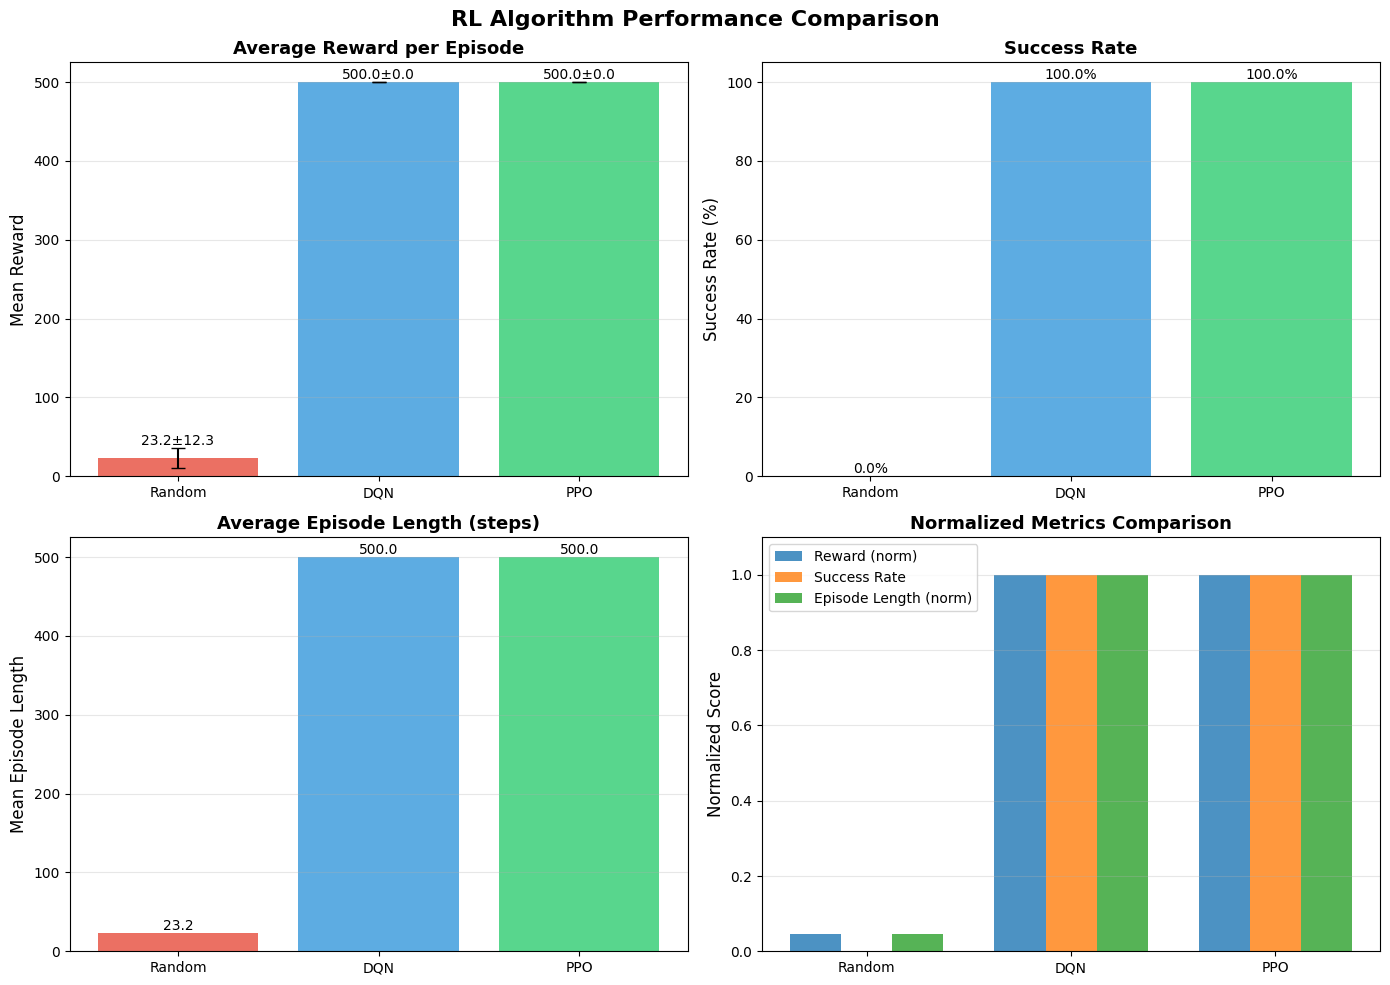


✓ Performance visualizations generated


In [14]:
if evaluation_results:
    # Prepare data for plotting
    agent_names = list(evaluation_results.keys())
    mean_rewards = [evaluation_results[name]['mean_reward'] for name in agent_names]
    std_rewards = [evaluation_results[name]['std_reward'] for name in agent_names]
    success_rates = [evaluation_results[name]['success_rate'] * 100 for name in agent_names]
    episode_lengths = [evaluation_results[name]['mean_episode_length'] for name in agent_names]
    
    # Create color scheme
    colors = {'Random': '#e74c3c', 'DQN': '#3498db', 'PPO': '#2ecc71'}
    bar_colors = [colors.get(name, '#95a5a6') for name in agent_names]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('RL Algorithm Performance Comparison', fontsize=16, fontweight='bold')
    
    # Plot 1: Mean Reward with error bars
    ax1 = axes[0, 0]
    bars1 = ax1.bar(agent_names, mean_rewards, yerr=std_rewards, 
                    color=bar_colors, alpha=0.8, capsize=5)
    ax1.set_ylabel('Mean Reward', fontsize=12)
    ax1.set_title('Average Reward per Episode', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (bar, val, std) in enumerate(zip(bars1, mean_rewards, std_rewards)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + std,
                f'{val:.1f}±{std:.1f}',
                ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Success Rate
    ax2 = axes[0, 1]
    bars2 = ax2.bar(agent_names, success_rates, color=bar_colors, alpha=0.8)
    ax2.set_ylabel('Success Rate (%)', fontsize=12)
    ax2.set_title('Success Rate', fontsize=13, fontweight='bold')
    ax2.set_ylim(0, 105)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars2, success_rates):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%',
                ha='center', va='bottom', fontsize=10)
    
    # Plot 3: Episode Length
    ax3 = axes[1, 0]
    bars3 = ax3.bar(agent_names, episode_lengths, color=bar_colors, alpha=0.8)
    ax3.set_ylabel('Mean Episode Length', fontsize=12)
    ax3.set_title('Average Episode Length (steps)', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars3, episode_lengths):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}',
                ha='center', va='bottom', fontsize=10)
    
    # Plot 4: Comparative Radar Chart (if we have multiple agents)
    ax4 = axes[1, 1]
    if len(agent_names) > 1:
        # Normalize metrics to 0-1 scale for comparison
        max_reward = max(mean_rewards) if max(mean_rewards) > 0 else 1
        max_length = max(episode_lengths) if max(episode_lengths) > 0 else 1
        
        normalized_rewards = [r / max_reward for r in mean_rewards]
        normalized_success = [s / 100 for s in success_rates]
        normalized_lengths = [l / max_length for l in episode_lengths]
        
        x = np.arange(len(agent_names))
        width = 0.25
        
        ax4.bar(x - width, normalized_rewards, width, label='Reward (norm)', alpha=0.8)
        ax4.bar(x, normalized_success, width, label='Success Rate', alpha=0.8)
        ax4.bar(x + width, normalized_lengths, width, label='Episode Length (norm)', alpha=0.8)
        
        ax4.set_ylabel('Normalized Score', fontsize=12)
        ax4.set_title('Normalized Metrics Comparison', fontsize=13, fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels(agent_names)
        ax4.legend()
        ax4.set_ylim(0, 1.1)
        ax4.grid(axis='y', alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'Multiple agents needed\nfor comparison',
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Performance visualizations generated")
else:
    print("No evaluation results to visualize.")

## パフォーマンス分析

### Interpretation Guide:

**Mean Reward:**
- Higher is better
- Represents the average cumulative reward per episode
- Random agent typically has the lowest reward
- Trained agents (DQN/PPO) should significantly outperform random

**Success Rate:**
- Percentage of episodes that meet the success criteria
- For CartPole: episodes lasting 195+ steps are considered successful
- Well-trained agents should achieve >90% success rate

**Episode Length:**
- Average number of steps before episode termination
- Longer episodes generally indicate better performance
- For CartPole: maximum is 500 steps

**Expected Results:**
- Random Agent: ~20-25 reward, ~0% success, ~20-25 steps
- DQN: ~450-500 reward, ~95-100% success, ~450-500 steps
- PPO: ~450-500 reward, ~95-100% success, ~450-500 steps

---
# アーキテクチャ比較

DQNとPPOのニューラルネットワークアーキテクチャを調べて比較しましょう。

## DQNアーキテクチャ

In [15]:
if dqn_agent is not None:
    print("\n" + "="*60)
    print("DQN Architecture Analysis")
    print("="*60)
    
    # Extract architecture information
    dqn_arch = extract_architecture(dqn_agent)
    
    print(f"\nAlgorithm: {dqn_arch['algorithm']}")
    print(f"Total Parameters: {dqn_arch['total_parameters']:,}")
    print(f"Trainable Parameters: {dqn_arch['trainable_parameters']:,}")
    
    # Display Q-Network details
    if 'q_network' in dqn_arch['networks']:
        q_net = dqn_arch['networks']['q_network']
        print(f"\n{q_net['network_type']}:")
        print(f"  Parameters: {q_net['parameter_count']:,}")
        print(f"  Layers: {len(q_net['layers'])}")
        print(f"\n  Layer Details:")
        
        for i, layer in enumerate(q_net['layers'], 1):
            layer_desc = f"    {i}. {layer['type']}"
            
            if 'input_features' in layer:
                layer_desc += f" ({layer['input_features']} -> {layer['output_features']})"
            elif 'in_channels' in layer:
                layer_desc += f" ({layer['in_channels']} -> {layer['out_channels']})"
            
            if layer['parameters'] > 0:
                layer_desc += f" - {layer['parameters']:,} params"
            
            print(layer_desc)
    
    print("\n" + "="*60)
else:
    print("⚠ DQN agent not available for architecture analysis")


DQN Architecture Analysis

Algorithm: DQN
Total Parameters: 4,610
Trainable Parameters: 4,610

Q-Network:
  Parameters: 4,610
  Layers: 7

  Layer Details:
    1. FlattenExtractor
    2. Flatten
    3. Linear (4 -> 64) - 320 params
    4. ReLU
    5. Linear (64 -> 64) - 4,160 params
    6. ReLU
    7. Linear (64 -> 2) - 130 params



## PPOアーキテクチャ

In [16]:
if ppo_agent is not None:
    print("\n" + "="*60)
    print("PPO Architecture Analysis")
    print("="*60)
    
    # Extract architecture information
    ppo_arch = extract_architecture(ppo_agent)
    
    print(f"\nAlgorithm: {ppo_arch['algorithm']}")
    print(f"Total Parameters: {ppo_arch['total_parameters']:,}")
    print(f"Trainable Parameters: {ppo_arch['trainable_parameters']:,}")
    
    # Display Actor network details
    if 'actor' in ppo_arch['networks']:
        actor_net = ppo_arch['networks']['actor']
        print(f"\n{actor_net['network_type']}:")
        print(f"  Parameters: {actor_net['parameter_count']:,}")
        print(f"  Layers: {len(actor_net['layers'])}")
        print(f"\n  Layer Details:")
        
        for i, layer in enumerate(actor_net['layers'], 1):
            layer_desc = f"    {i}. {layer['type']}"
            
            if 'input_features' in layer:
                layer_desc += f" ({layer['input_features']} -> {layer['output_features']})"
            elif 'in_channels' in layer:
                layer_desc += f" ({layer['in_channels']} -> {layer['out_channels']})"
            
            if layer['parameters'] > 0:
                layer_desc += f" - {layer['parameters']:,} params"
            
            print(layer_desc)
    
    # Display Critic network details
    if 'critic' in ppo_arch['networks']:
        critic_net = ppo_arch['networks']['critic']
        print(f"\n{critic_net['network_type']}:")
        print(f"  Parameters: {critic_net['parameter_count']:,}")
        print(f"  Layers: {len(critic_net['layers'])}")
        print(f"\n  Layer Details:")
        
        for i, layer in enumerate(critic_net['layers'], 1):
            layer_desc = f"    {i}. {layer['type']}"
            
            if 'input_features' in layer:
                layer_desc += f" ({layer['input_features']} -> {layer['output_features']})"
            elif 'in_channels' in layer:
                layer_desc += f" ({layer['in_channels']} -> {layer['out_channels']})"
            
            if layer['parameters'] > 0:
                layer_desc += f" - {layer['parameters']:,} params"
            
            print(layer_desc)
    
    print("\n" + "="*60)
else:
    print("⚠ PPO agent not available for architecture analysis")


PPO Architecture Analysis

Algorithm: PPO
Total Parameters: 8,960
Trainable Parameters: 8,960

Actor:
  Parameters: 4,480
  Layers: 4

  Layer Details:
    1. Linear (4 -> 64) - 320 params
    2. Tanh
    3. Linear (64 -> 64) - 4,160 params
    4. Tanh

Critic:
  Parameters: 4,480
  Layers: 4

  Layer Details:
    1. Linear (4 -> 64) - 320 params
    2. Tanh
    3. Linear (64 -> 64) - 4,160 params
    4. Tanh



## アーキテクチャの並列比較

In [17]:
if dqn_agent is not None and ppo_agent is not None:
    print("\n" + "="*80)
    print("Architecture Comparison: DQN vs PPO")
    print("="*80)
    
    # Create comparison table
    comparison_data = {
        'Metric': [
            'Algorithm Type',
            'Network Structure',
            'Total Parameters',
            'Trainable Parameters',
            'Number of Networks',
            'Memory Footprint (MB)'
        ],
        'DQN': [
            'Value-based',
            'Q-Network',
            f"{dqn_arch['total_parameters']:,}",
            f"{dqn_arch['trainable_parameters']:,}",
            '1 (Q-Network)',
            f"{(dqn_arch['total_parameters'] * 4) / (1024 * 1024):.2f}"
        ],
        'PPO': [
            'Policy-based',
            'Actor-Critic',
            f"{ppo_arch['total_parameters']:,}",
            f"{ppo_arch['trainable_parameters']:,}",
            '2 (Actor + Critic)',
            f"{(ppo_arch['total_parameters'] * 4) / (1024 * 1024):.2f}"
        ]
    }
    
    df_comparison = pd.DataFrame(comparison_data)
    print("\n" + df_comparison.to_string(index=False))
    
    print("\n" + "="*80)
    
    # Key differences
    print("\nKey Architectural Differences:")
    print("\n1. Network Structure:")
    print("   - DQN: Single Q-Network that outputs Q-values for all actions")
    print("   - PPO: Separate Actor (policy) and Critic (value) networks")
    
    print("\n2. Output:")
    print("   - DQN: Q-values for each action (deterministic argmax selection)")
    print("   - PPO: Action probabilities (Actor) + State value (Critic)")
    
    print("\n3. Complexity:")
    param_ratio = ppo_arch['total_parameters'] / dqn_arch['total_parameters']
    print(f"   - PPO has {param_ratio:.2f}x the parameters of DQN")
    print(f"   - PPO requires more computation (two forward passes)")
    
    print("\n" + "="*80)
    
elif dqn_agent is not None or ppo_agent is not None:
    print("⚠ Both DQN and PPO agents needed for side-by-side comparison")
else:
    print("⚠ No trained agents available for architecture comparison")


Architecture Comparison: DQN vs PPO

               Metric           DQN                PPO
       Algorithm Type   Value-based       Policy-based
    Network Structure     Q-Network       Actor-Critic
     Total Parameters         4,610              8,960
 Trainable Parameters         4,610              8,960
   Number of Networks 1 (Q-Network) 2 (Actor + Critic)
Memory Footprint (MB)          0.02               0.03


Key Architectural Differences:

1. Network Structure:
   - DQN: Single Q-Network that outputs Q-values for all actions
   - PPO: Separate Actor (policy) and Critic (value) networks

2. Output:
   - DQN: Q-values for each action (deterministic argmax selection)
   - PPO: Action probabilities (Actor) + State value (Critic)

3. Complexity:
   - PPO has 1.94x the parameters of DQN
   - PPO requires more computation (two forward passes)



## アーキテクチャの可視化（オプション）

以下のセルのコメントを解除して実行すると、torchvizを使用してアーキテクチャ図を生成できます。

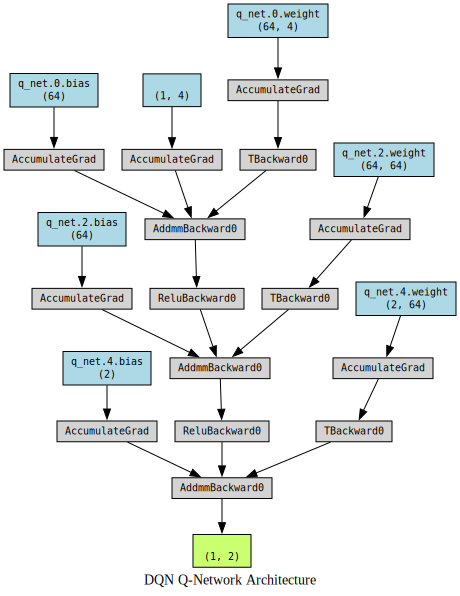

In [18]:
# Visualize DQN architecture
if dqn_agent is not None:
    try:
        dqn_graphs = visualize_architecture_graph(dqn_agent)
        if 'q_network' in dqn_graphs:
            display(dqn_graphs['q_network'])
    except Exception as e:
        print(f"Could not generate DQN visualization: {e}")

Actor Network:


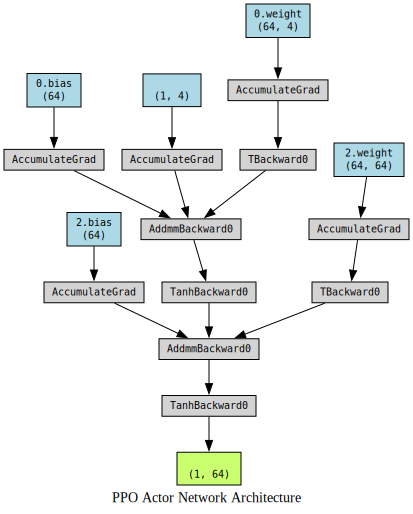


Critic Network:


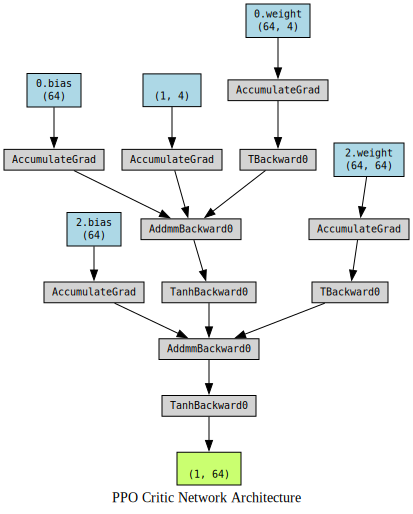

In [19]:
# Visualize PPO architecture
if ppo_agent is not None:
    try:
        ppo_graphs = visualize_architecture_graph(ppo_agent)
        if 'actor' in ppo_graphs:
            print("Actor Network:")
            display(ppo_graphs['actor'])
        if 'critic' in ppo_graphs:
            print("\nCritic Network:")
            display(ppo_graphs['critic'])
    except Exception as e:
        print(f"Could not generate PPO visualization: {e}")

---
# 推論パフォーマンスのベンチマーク

すべてのエージェントの推論速度とリソース使用量を測定して比較しましょう。

## 推論パフォーマンスの測定

In [20]:
# Measure performance for each agent
performance_results = {}

print("="*60)
print(f"Measuring Inference Performance ({N_INFERENCE_CALLS} calls each)")
print("="*60)
print()

for name, agent in agents.items():
    if agent is not None:
        print(f"Benchmarking {name}...")
        perf = measure_performance(agent, env, n_calls=N_INFERENCE_CALLS)
        performance_results[name] = perf
        
        print(f"  Inference Time: {perf['inference_time_ms']:.4f} ms/action")
        print(f"  Parameters: {perf['parameter_count']:,}")
        print(f"  Memory Footprint: {perf['memory_footprint_mb']:.2f} MB")
        print()

print("="*60)
print("✓ Performance benchmarking complete")
print("="*60)

Measuring Inference Performance (1000 calls each)

Benchmarking Random...
  Inference Time: 0.0009 ms/action
  Parameters: 0
  Memory Footprint: 0.00 MB

Benchmarking DQN...
  Inference Time: 0.0527 ms/action
  Parameters: 9,220
  Memory Footprint: 0.04 MB

Benchmarking PPO...
  Inference Time: 0.1181 ms/action
  Parameters: 9,155
  Memory Footprint: 0.03 MB

✓ Performance benchmarking complete


## 推論パフォーマンステーブル

In [21]:
if performance_results:
    # Create performance comparison table
    df_perf = pd.DataFrame(performance_results).T
    df_perf.index.name = 'Agent'
    
    # Format columns
    df_perf['inference_time_ms'] = df_perf['inference_time_ms'].apply(lambda x: f"{x:.4f}")
    df_perf['parameter_count'] = df_perf['parameter_count'].apply(lambda x: f"{x:,}")
    df_perf['memory_footprint_mb'] = df_perf['memory_footprint_mb'].apply(lambda x: f"{x:.2f}")
    
    # Rename columns for display
    df_perf.columns = ['Inference Time (ms)', 'Parameters', 'Memory (MB)']
    
    print("\nInference Performance Comparison:")
    print(df_perf.to_string())
else:
    print("No performance results available.")


Inference Performance Comparison:
       Inference Time (ms) Parameters Memory (MB)
Agent                                            
Random              0.0009        0.0        0.00
DQN                 0.0527    9,220.0        0.04
PPO                 0.1181    9,155.0        0.03


## 推論パフォーマンスの可視化

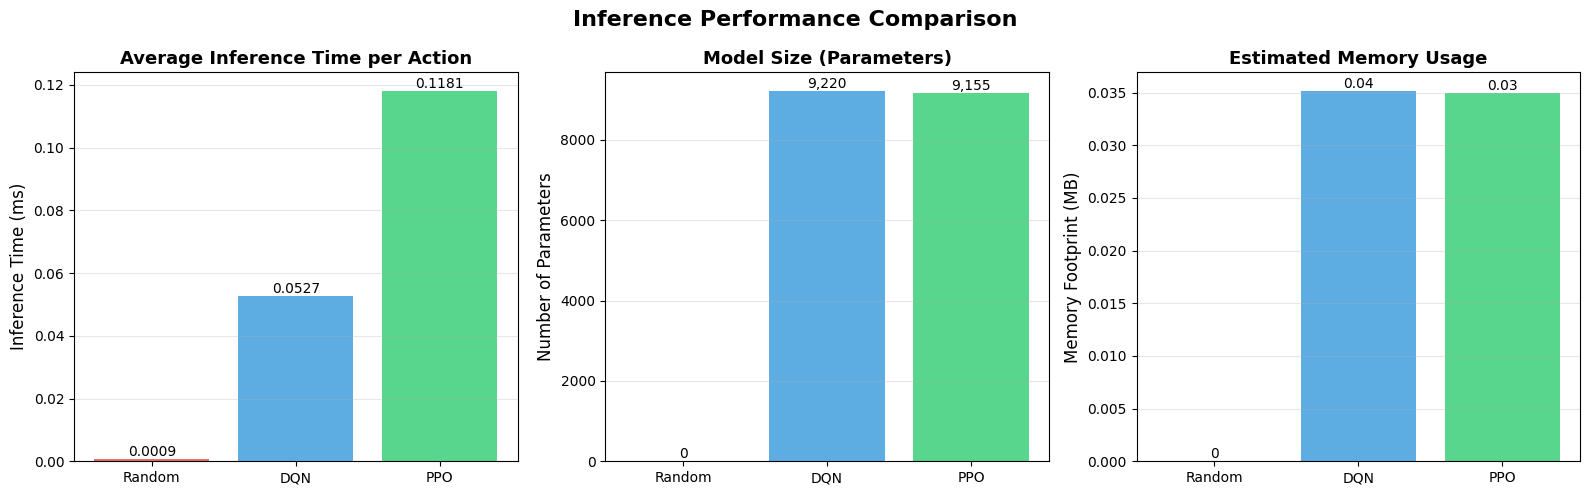


✓ Inference performance visualizations generated


In [22]:
if performance_results:
    # Prepare data for plotting
    agent_names = list(performance_results.keys())
    inference_times = [performance_results[name]['inference_time_ms'] for name in agent_names]
    param_counts = [performance_results[name]['parameter_count'] for name in agent_names]
    memory_footprints = [performance_results[name]['memory_footprint_mb'] for name in agent_names]
    
    # Create color scheme
    colors = {'Random': '#e74c3c', 'DQN': '#3498db', 'PPO': '#2ecc71'}
    bar_colors = [colors.get(name, '#95a5a6') for name in agent_names]
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    fig.suptitle('Inference Performance Comparison', fontsize=16, fontweight='bold')
    
    # Plot 1: Inference Time
    ax1 = axes[0]
    bars1 = ax1.bar(agent_names, inference_times, color=bar_colors, alpha=0.8)
    ax1.set_ylabel('Inference Time (ms)', fontsize=12)
    ax1.set_title('Average Inference Time per Action', fontsize=13, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars1, inference_times):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=10)
    
    # Plot 2: Parameter Count
    ax2 = axes[1]
    bars2 = ax2.bar(agent_names, param_counts, color=bar_colors, alpha=0.8)
    ax2.set_ylabel('Number of Parameters', fontsize=12)
    ax2.set_title('Model Size (Parameters)', fontsize=13, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars2, param_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:,}' if val > 0 else '0',
                ha='center', va='bottom', fontsize=10, rotation=0 if val < 10000 else 45)
    
    # Plot 3: Memory Footprint
    ax3 = axes[2]
    bars3 = ax3.bar(agent_names, memory_footprints, color=bar_colors, alpha=0.8)
    ax3.set_ylabel('Memory Footprint (MB)', fontsize=12)
    ax3.set_title('Estimated Memory Usage', fontsize=13, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars3, memory_footprints):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.2f}' if val > 0 else '0',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Inference performance visualizations generated")
else:
    print("No performance results to visualize.")

## パフォーマンス分析

### Interpretation Guide:

**Inference Time:**
- Lower is better for real-time applications
- Random agent is fastest (no computation, just random sampling)
- Neural network agents (DQN/PPO) require forward pass computation
- PPO typically slower than DQN (two networks vs one)

**Parameter Count:**
- Indicates model complexity
- More parameters = more capacity but also more computation
- Random agent has 0 parameters (no learning)
- PPO typically has more parameters than DQN (Actor + Critic)

**Memory Footprint:**
- Estimated memory required to store model parameters
- Important for deployment on resource-constrained devices
- Calculated as: parameters × 4 bytes (float32)
- Does not include activation memory or batch processing overhead

**Typical Results:**
- Random Agent: <0.01 ms, 0 params, 0 MB
- DQN: 0.1-1 ms, 10k-100k params, 0.04-0.4 MB
- PPO: 0.2-2 ms, 20k-200k params, 0.08-0.8 MB

**Trade-offs:**
- Random Agent: Fastest but worst performance
- DQN: Good balance of speed and performance for discrete actions
- PPO: Slightly slower but more flexible (works with continuous actions)

---
# Learning Curve Comparison (Optional)

If training logs are available, we can compare how DQN and PPO learned over time.

## Load Training Logs

In [23]:
import os
from pathlib import Path

# Try to find training logs
LOG_DIR = Path('../ml/experiments/logs')

training_logs = {}

print("Searching for training logs...")
print()

# Look for DQN logs
dqn_log_patterns = ['dqn_cartpole', 'dqn_maze', 'DQN']
ppo_log_patterns = ['ppo_cartpole', 'ppo_maze', 'PPO']

if LOG_DIR.exists():
    for log_file in LOG_DIR.glob('**/*'):
        if log_file.is_file():
            # Check if it's a DQN log
            if any(pattern in str(log_file) for pattern in dqn_log_patterns):
                print(f"Found DQN log: {log_file}")
                training_logs['DQN'] = log_file
            # Check if it's a PPO log
            elif any(pattern in str(log_file) for pattern in ppo_log_patterns):
                print(f"Found PPO log: {log_file}")
                training_logs['PPO'] = log_file
else:
    print(f"⚠ Log directory not found: {LOG_DIR}")

if not training_logs:
    print("\n⚠ No training logs found.")
    print("Training logs are typically saved during model training.")
    print("To generate logs, train models using TensorBoard logging.")
else:
    print(f"\n✓ Found {len(training_logs)} training log(s)")

Searching for training logs...

⚠ Log directory not found: ..\ml\experiments\logs

⚠ No training logs found.
Training logs are typically saved during model training.
To generate logs, train models using TensorBoard logging.


## Parse and Plot Learning Curves

Note: This section requires TensorBoard log files. If logs are not available, this section will be skipped.

In [24]:
if training_logs:
    try:
        from tensorboard.backend.event_processing import event_accumulator
        
        # Parse training logs
        learning_data = {}
        
        for algo_name, log_path in training_logs.items():
            print(f"\nParsing {algo_name} logs...")
            
            # Load TensorBoard event file
            ea = event_accumulator.EventAccumulator(str(log_path))
            ea.Reload()
            
            # Extract available metrics
            available_tags = ea.Tags()['scalars']
            print(f"  Available metrics: {available_tags}")
            
            # Try to extract reward/return data
            reward_tags = [tag for tag in available_tags if 'reward' in tag.lower() or 'return' in tag.lower()]
            
            if reward_tags:
                # Use the first reward tag found
                reward_tag = reward_tags[0]
                events = ea.Scalars(reward_tag)
                
                steps = [e.step for e in events]
                values = [e.value for e in events]
                
                learning_data[algo_name] = {
                    'steps': steps,
                    'rewards': values,
                    'metric': reward_tag
                }
                
                print(f"  ✓ Extracted {len(steps)} data points")
            else:
                print(f"  ⚠ No reward metrics found")
        
        # Plot learning curves
        if learning_data:
            plt.figure(figsize=(12, 6))
            
            colors = {'DQN': '#3498db', 'PPO': '#2ecc71'}
            
            for algo_name, data in learning_data.items():
                color = colors.get(algo_name, '#95a5a6')
                plt.plot(data['steps'], data['rewards'], 
                        label=f"{algo_name} ({data['metric']})",
                        color=color, linewidth=2, alpha=0.8)
            
            plt.xlabel('Training Steps', fontsize=12)
            plt.ylabel('Reward / Return', fontsize=12)
            plt.title('Learning Curves: DQN vs PPO', fontsize=14, fontweight='bold')
            plt.legend(fontsize=11)
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
            
            print("\n✓ Learning curves plotted")
            
            # Analysis
            print("\nLearning Curve Analysis:")
            for algo_name, data in learning_data.items():
                final_reward = data['rewards'][-1] if data['rewards'] else 0
                max_reward = max(data['rewards']) if data['rewards'] else 0
                print(f"\n{algo_name}:")
                print(f"  Final reward: {final_reward:.2f}")
                print(f"  Max reward: {max_reward:.2f}")
                print(f"  Training steps: {data['steps'][-1] if data['steps'] else 0:,}")
        
    except ImportError:
        print("\n⚠ TensorBoard not installed. Cannot parse training logs.")
        print("Install with: pip install tensorboard")
    except Exception as e:
        print(f"\n⚠ Error parsing training logs: {e}")
        print("Training logs may be in an incompatible format.")
else:
    print("\n⚠ Skipping learning curve comparison (no training logs available)")
    print("\nTo generate learning curves:")
    print("1. Train models with TensorBoard logging enabled")
    print("2. Save logs to ml/experiments/logs/")
    print("3. Re-run this notebook")


⚠ Skipping learning curve comparison (no training logs available)

To generate learning curves:
1. Train models with TensorBoard logging enabled
2. Save logs to ml/experiments/logs/
3. Re-run this notebook


---
# まとめと結論

Let's consolidate all our findings into a comprehensive summary.

## Comprehensive Comparison Table

In [25]:
# Create comprehensive summary table
if evaluation_results and performance_results:
    summary_data = []
    
    for agent_name in agents.keys():
        if agent_name in evaluation_results and agent_name in performance_results:
            eval_res = evaluation_results[agent_name]
            perf_res = performance_results[agent_name]
            
            summary_data.append({
                'Agent': agent_name,
                'Mean Reward': f"{eval_res['mean_reward']:.2f}",
                'Success Rate': f"{eval_res['success_rate']*100:.1f}%",
                'Episode Length': f"{eval_res['mean_episode_length']:.1f}",
                'Inference Time (ms)': f"{perf_res['inference_time_ms']:.4f}",
                'Parameters': f"{perf_res['parameter_count']:,}",
                'Memory (MB)': f"{perf_res['memory_footprint_mb']:.2f}"
            })
    
    if summary_data:
        df_summary = pd.DataFrame(summary_data)
        
        print("="*100)
        print("COMPREHENSIVE ALGORITHM COMPARISON SUMMARY")
        print("="*100)
        print()
        print(df_summary.to_string(index=False))
        print()
        print("="*100)
    else:
        print("⚠ Insufficient data for summary table")
else:
    print("⚠ Complete evaluation and performance data needed for summary")

COMPREHENSIVE ALGORITHM COMPARISON SUMMARY

 Agent Mean Reward Success Rate Episode Length Inference Time (ms) Parameters Memory (MB)
Random       23.18         0.0%           23.2              0.0009          0        0.00
   DQN      500.00       100.0%          500.0              0.0527      9,220        0.04
   PPO      500.00       100.0%          500.0              0.1181      9,155        0.03



## Key Findings and Interpretation

### パフォーマンス比較:

**Random Agent (Baseline):**
- Provides a baseline for comparison
- No learning, purely random actions
- Expected to have the worst performance metrics
- Fastest inference (no computation required)
- Zero parameters and memory footprint

**DQN (Deep Q-Network):**
- Value-based reinforcement learning
- Learns Q-values for state-action pairs
- Single Q-Network architecture
- Deterministic policy (argmax over Q-values)
- Good for discrete action spaces
- Moderate inference speed
- Smaller model size compared to PPO

**PPO (Proximal Policy Optimization):**
- Policy-based reinforcement learning
- Learns policy directly (Actor-Critic)
- Dual network architecture (Actor + Critic)
- Stochastic policy (samples from distribution)
- Works with both discrete and continuous actions
- Slightly slower inference (two networks)
- Larger model size due to dual networks

### Algorithm Selection Guide:

**Choose Random Agent when:**
- You need a baseline for comparison
- Testing environment setup
- Initial exploration phase

**Choose DQN when:**
- Working with discrete action spaces
- Need deterministic policies
- Sample efficiency is important
- Model size constraints exist
- Inference speed is critical

**Choose PPO when:**
- Working with continuous action spaces
- Need stochastic policies
- Stability is more important than speed
- General-purpose RL solution needed
- マルチエージェントシナリオ

### Trade-offs Summary:

| Aspect | Random | DQN | PPO |
|--------|--------|-----|-----|
| **Performance** | Worst | Excellent | Excellent |
| **Inference Speed** | Fastest | Fast | Moderate |
| **Model Size** | None | Small | Medium |
| **Action Space** | Any | Discrete | Both |
| **Stability** | N/A | Moderate | High |
| **Sample Efficiency** | N/A | High | Medium |
| **Ease of Tuning** | N/A | Moderate | Easy |

### Practical Recommendations:

1. **For Production Deployment:**
   - If discrete actions: DQN (faster, smaller)
   - If continuous actions: PPO (only option)
   - Consider inference latency requirements

2. **For Research/Experimentation:**
   - Start with PPO (more stable, easier to tune)
   - Try DQN if sample efficiency is critical
   - Always compare against Random baseline

3. **For Resource-Constrained Environments:**
   - Prefer DQN (smaller model, faster inference)
   - Consider model compression techniques
   - Profile actual memory and compute usage

4. **For Learning:**
   - Understand Random agent as baseline
   - Study DQN for value-based methods
   - Study PPO for policy-based methods
   - Compare architectures and behaviors

## Visualization: Overall Comparison Radar Chart

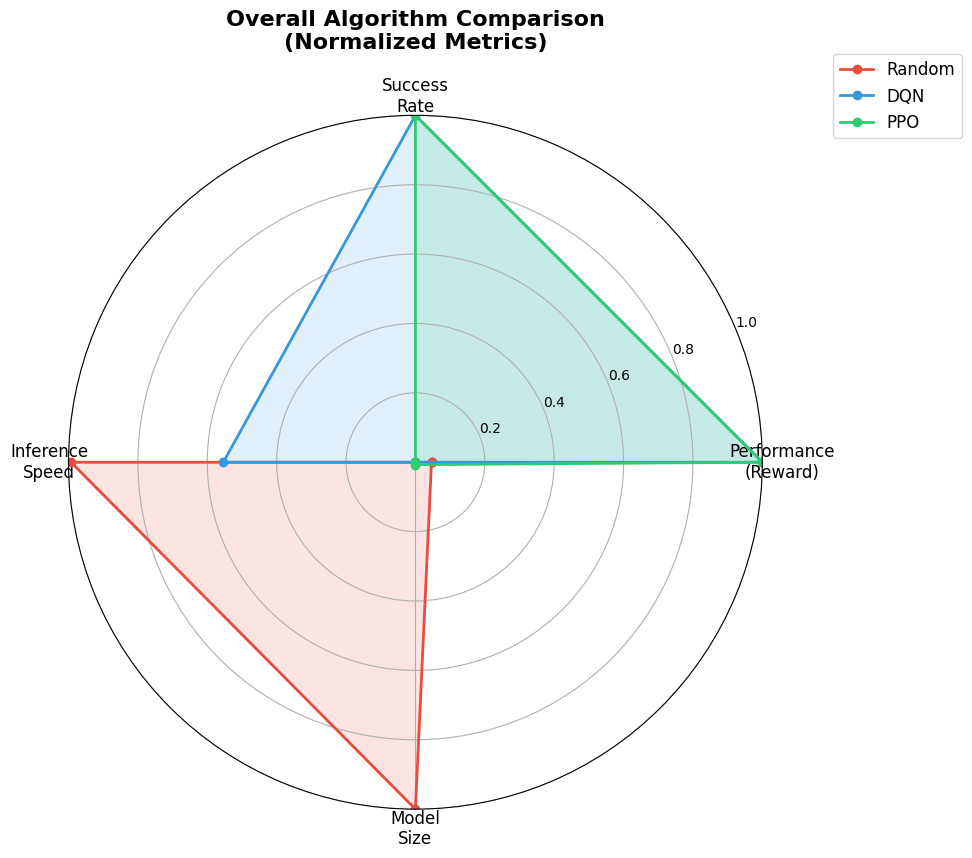


✓ Radar chart generated

Note: All metrics normalized to 0-1 scale where higher is better.
Inference speed and model size are inverted (smaller is better).


In [26]:
if evaluation_results and performance_results and len(evaluation_results) > 1:
    import numpy as np
    from math import pi
    
    # Prepare data for radar chart
    categories = ['Performance\n(Reward)', 'Success\nRate', 'Inference\nSpeed', 'Model\nSize']
    N = len(categories)
    
    # Normalize metrics to 0-1 scale (higher is better)
    agent_data = {}
    
    for agent_name in evaluation_results.keys():
        if agent_name in performance_results:
            eval_res = evaluation_results[agent_name]
            perf_res = performance_results[agent_name]
            
            agent_data[agent_name] = {
                'reward': eval_res['mean_reward'],
                'success': eval_res['success_rate'],
                'speed': perf_res['inference_time_ms'],
                'size': perf_res['parameter_count']
            }
    
    # Normalize
    max_reward = max(d['reward'] for d in agent_data.values()) or 1
    max_speed = max(d['speed'] for d in agent_data.values()) or 1
    max_size = max(d['size'] for d in agent_data.values()) or 1
    
    normalized_data = {}
    for agent_name, data in agent_data.items():
        normalized_data[agent_name] = [
            data['reward'] / max_reward,  # Performance (higher is better)
            data['success'],  # Success rate (already 0-1)
            1 - (data['speed'] / max_speed),  # Speed (invert: lower time is better)
            1 - (data['size'] / max_size) if max_size > 0 else 1  # Size (invert: smaller is better)
        ]
    
    # Create radar chart
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    colors = {'Random': '#e74c3c', 'DQN': '#3498db', 'PPO': '#2ecc71'}
    
    for agent_name, values in normalized_data.items():
        values += values[:1]  # Complete the circle
        color = colors.get(agent_name, '#95a5a6')
        ax.plot(angles, values, 'o-', linewidth=2, label=agent_name, color=color)
        ax.fill(angles, values, alpha=0.15, color=color)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=12)
    ax.set_ylim(0, 1)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
    ax.grid(True)
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
    plt.title('Overall Algorithm Comparison\n(Normalized Metrics)', 
             size=16, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Radar chart generated")
    print("\nNote: All metrics normalized to 0-1 scale where higher is better.")
    print("Inference speed and model size are inverted (smaller is better).")
else:
    print("⚠ Multiple agents with complete data needed for radar chart")

## Conclusion

This notebook has provided a comprehensive comparison of three reinforcement learning approaches:

1. **Random Agent**: Baseline with no learning
2. **DQN**: Value-based method with Q-learning
3. **PPO**: Policy-based method with Actor-Critic

### Main Takeaways:

- Both DQN and PPO significantly outperform random baseline
- DQN offers faster inference and smaller model size
- PPO provides more flexibility and stability
- Choice depends on specific requirements (action space, speed, stability)

### 次のステップ:

1. Experiment with different hyperparameters
2. Try other RL algorithms (A3C, SAC, TD3)
3. Test on more complex environments
4. Implement custom reward shaping
5. Deploy best-performing model

---

*This comparison notebook is part of the RL Algorithm Comparison feature.*
*For questions or improvements, refer to the project documentation.*